# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 14            
model_seed = 4           

# --- Training configuration ---
save_epochs = [200, 400, 600, 800, 1000, 1500, 2000, 3000, 5000]

# --- Dataset configuration ---
base_data_size = (int)(0.33*9409)
dataset_type = "data"   
dataset_quantities = [0] # modulo arithmetic dataset sizes

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    



## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
from minima_volume.models import modulo_arithmetic_model_data as model_module
modulus = 97
# Generate dataset - for modulo arithmetic generates a large set
x_base, y_base, x_test, y_test = model_module.get_dataset(
    modulus = modulus,
    device = device,
)

# MNIST specific initialization parameters
hidden_dims = [250]

# Grab model
model_template = model_module.get_model(N = modulus, hidden_dims=hidden_dims, device=device, seed=model_seed)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [4]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

# Assemble training dataset
# No additional data here! Just the base dataset.
additional_data = 0
x_train = x_base_train
y_train = y_base_train

# Initialize model (defined in the model-specific file)
torch.manual_seed(model_seed)
model = copy.deepcopy(model_template)
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
batch_size = len(x_train)

# Initialize lists to accumulate metrics across all epochs
all_train_loss = []
all_test_loss = []
all_train_other_metrics = []  # Will store dicts for each epoch
all_test_other_metrics = []   # Will store dicts for each epoch

# Train model incrementally for each interval in save_epochs
previous_epoch = 0

for current_save_epoch in save_epochs:
    epochs_to_train = current_save_epoch - previous_epoch
    
    print(f"Training from epoch {previous_epoch} to {current_save_epoch} ({epochs_to_train} epochs)")
    
    # Train for the current interval
    train_loss, train_other_metrics, test_loss, test_other_metrics = train(
        model=model,
        x_train=x_train, y_train=y_train,
        x_test=x_test, y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics,
        optimizer=optimizer,
        epochs=epochs_to_train,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Append the new metrics to the accumulated lists
    all_train_loss.extend(train_loss)
    all_test_loss.extend(test_loss)
    all_train_other_metrics.extend(train_other_metrics)
    all_test_other_metrics.extend(test_other_metrics)
    
    # Build dictionary dynamically for additional metrics (for the entire training so far)
    train_metrics_dict = {}
    test_metrics_dict = {}
    
    if all_train_other_metrics and len(all_train_other_metrics) > 0:
        # Use keys from first available epoch dict
        for metric_name in all_train_other_metrics[0].keys():
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in all_train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in all_test_other_metrics]
    
    # Store results for current checkpoint
    trained_model = {
        "model": copy.deepcopy(model),  # Save a copy of the model at this checkpoint
        "train_loss": all_train_loss.copy(),  # Copy to avoid reference issues
        "test_loss": all_test_loss.copy(),
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        "total_epochs_trained": current_save_epoch,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)
    
    print(f"Completed training up to {current_save_epoch} epochs!")
    
    # Update previous epoch for next interval
    previous_epoch = current_save_epoch

# Free memory (important for large GPU datasets)
del x_train, y_train
torch.cuda.empty_cache()


Training from epoch 0 to 200 (200 epochs)


Epoch 1/200: Train Loss 0.0123 | Test Loss 0.0118 | accs Train 0.0106 Test 0.0108


Epoch 100/200: Train Loss 0.0090 | Test Loss 0.0105 | accs Train 0.8396 Test 0.2778


Epoch 200/200: Train Loss 0.0078 | Test Loss 0.0110 | accs Train 0.9613 Test 0.3186
Completed training up to 200 epochs!
Training from epoch 200 to 400 (200 epochs)
Epoch 1/200: Train Loss 0.0078 | Test Loss 0.0110 | accs Train 0.9620 Test 0.3185


Epoch 100/200: Train Loss 0.0070 | Test Loss 0.0113 | accs Train 0.9861 Test 0.3292


Epoch 200/200: Train Loss 0.0066 | Test Loss 0.0114 | accs Train 0.9939 Test 0.3357
Completed training up to 400 epochs!
Training from epoch 400 to 600 (200 epochs)
Epoch 1/200: Train Loss 0.0066 | Test Loss 0.0114 | accs Train 0.9939 Test 0.3361


Epoch 100/200: Train Loss 0.0063 | Test Loss 0.0114 | accs Train 0.9968 Test 0.3438


Epoch 200/200: Train Loss 0.0061 | Test Loss 0.0113 | accs Train 0.9977 Test 0.3549
Completed training up to 600 epochs!
Training from epoch 600 to 800 (200 epochs)
Epoch 1/200: Train Loss 0.0061 | Test Loss 0.0113 | accs Train 0.9977 Test 0.3550


Epoch 100/200: Train Loss 0.0058 | Test Loss 0.0111 | accs Train 0.9994 Test 0.3762


Epoch 200/200: Train Loss 0.0056 | Test Loss 0.0108 | accs Train 0.9994 Test 0.4097
Completed training up to 800 epochs!
Training from epoch 800 to 1000 (200 epochs)
Epoch 1/200: Train Loss 0.0056 | Test Loss 0.0108 | accs Train 0.9994 Test 0.4099


Epoch 100/200: Train Loss 0.0054 | Test Loss 0.0105 | accs Train 0.9997 Test 0.4584


Epoch 200/200: Train Loss 0.0052 | Test Loss 0.0102 | accs Train 0.9997 Test 0.5282
Completed training up to 1000 epochs!
Training from epoch 1000 to 1500 (500 epochs)
Epoch 1/500: Train Loss 0.0052 | Test Loss 0.0102 | accs Train 1.0000 Test 0.5297


Epoch 100/500: Train Loss 0.0051 | Test Loss 0.0099 | accs Train 1.0000 Test 0.6016


Epoch 200/500: Train Loss 0.0049 | Test Loss 0.0096 | accs Train 1.0000 Test 0.6778


Epoch 300/500: Train Loss 0.0047 | Test Loss 0.0093 | accs Train 1.0000 Test 0.7581


Epoch 400/500: Train Loss 0.0045 | Test Loss 0.0089 | accs Train 1.0000 Test 0.8433


Epoch 500/500: Train Loss 0.0043 | Test Loss 0.0084 | accs Train 1.0000 Test 0.9135
Completed training up to 1500 epochs!
Training from epoch 1500 to 2000 (500 epochs)
Epoch 1/500: Train Loss 0.0043 | Test Loss 0.0084 | accs Train 1.0000 Test 0.9150


Epoch 100/500: Train Loss 0.0041 | Test Loss 0.0079 | accs Train 1.0000 Test 0.9628


Epoch 200/500: Train Loss 0.0038 | Test Loss 0.0073 | accs Train 1.0000 Test 0.9886


Epoch 300/500: Train Loss 0.0035 | Test Loss 0.0067 | accs Train 1.0000 Test 0.9966


Epoch 400/500: Train Loss 0.0033 | Test Loss 0.0062 | accs Train 1.0000 Test 0.9994


Epoch 500/500: Train Loss 0.0030 | Test Loss 0.0057 | accs Train 1.0000 Test 1.0000
Completed training up to 2000 epochs!
Training from epoch 2000 to 3000 (1000 epochs)
Epoch 1/1000: Train Loss 0.0030 | Test Loss 0.0057 | accs Train 1.0000 Test 1.0000


Epoch 100/1000: Train Loss 0.0028 | Test Loss 0.0053 | accs Train 1.0000 Test 1.0000


Epoch 200/1000: Train Loss 0.0026 | Test Loss 0.0049 | accs Train 1.0000 Test 1.0000


Epoch 300/1000: Train Loss 0.0024 | Test Loss 0.0046 | accs Train 1.0000 Test 1.0000


Epoch 400/1000: Train Loss 0.0023 | Test Loss 0.0043 | accs Train 1.0000 Test 1.0000


Epoch 500/1000: Train Loss 0.0022 | Test Loss 0.0041 | accs Train 1.0000 Test 1.0000


Epoch 600/1000: Train Loss 0.0021 | Test Loss 0.0040 | accs Train 1.0000 Test 1.0000


Epoch 700/1000: Train Loss 0.0020 | Test Loss 0.0039 | accs Train 1.0000 Test 1.0000


Epoch 800/1000: Train Loss 0.0020 | Test Loss 0.0037 | accs Train 1.0000 Test 1.0000


Epoch 900/1000: Train Loss 0.0019 | Test Loss 0.0036 | accs Train 1.0000 Test 1.0000


Epoch 1000/1000: Train Loss 0.0018 | Test Loss 0.0035 | accs Train 1.0000 Test 1.0000
Completed training up to 3000 epochs!
Training from epoch 3000 to 5000 (2000 epochs)
Epoch 1/2000: Train Loss 0.0018 | Test Loss 0.0035 | accs Train 1.0000 Test 1.0000


Epoch 100/2000: Train Loss 0.0018 | Test Loss 0.0035 | accs Train 1.0000 Test 1.0000


Epoch 200/2000: Train Loss 0.0018 | Test Loss 0.0034 | accs Train 1.0000 Test 1.0000


Epoch 300/2000: Train Loss 0.0017 | Test Loss 0.0033 | accs Train 1.0000 Test 1.0000


Epoch 400/2000: Train Loss 0.0017 | Test Loss 0.0032 | accs Train 1.0000 Test 1.0000


Epoch 500/2000: Train Loss 0.0016 | Test Loss 0.0032 | accs Train 1.0000 Test 1.0000


Epoch 600/2000: Train Loss 0.0016 | Test Loss 0.0031 | accs Train 1.0000 Test 1.0000


Epoch 700/2000: Train Loss 0.0016 | Test Loss 0.0031 | accs Train 1.0000 Test 1.0000


Epoch 800/2000: Train Loss 0.0015 | Test Loss 0.0030 | accs Train 1.0000 Test 1.0000


Epoch 900/2000: Train Loss 0.0015 | Test Loss 0.0030 | accs Train 1.0000 Test 1.0000


Epoch 1000/2000: Train Loss 0.0015 | Test Loss 0.0029 | accs Train 1.0000 Test 1.0000


Epoch 1100/2000: Train Loss 0.0015 | Test Loss 0.0029 | accs Train 1.0000 Test 1.0000


Epoch 1200/2000: Train Loss 0.0015 | Test Loss 0.0029 | accs Train 1.0000 Test 1.0000


Epoch 1300/2000: Train Loss 0.0014 | Test Loss 0.0029 | accs Train 1.0000 Test 1.0000


Epoch 1400/2000: Train Loss 0.0014 | Test Loss 0.0028 | accs Train 1.0000 Test 1.0000


Epoch 1500/2000: Train Loss 0.0014 | Test Loss 0.0028 | accs Train 1.0000 Test 1.0000


Epoch 1600/2000: Train Loss 0.0014 | Test Loss 0.0028 | accs Train 1.0000 Test 1.0000


Epoch 1700/2000: Train Loss 0.0014 | Test Loss 0.0027 | accs Train 1.0000 Test 1.0000


Epoch 1800/2000: Train Loss 0.0014 | Test Loss 0.0027 | accs Train 1.0000 Test 1.0000


Epoch 1900/2000: Train Loss 0.0013 | Test Loss 0.0027 | accs Train 1.0000 Test 1.0000


Epoch 2000/2000: Train Loss 0.0013 | Test Loss 0.0027 | accs Train 1.0000 Test 1.0000
Completed training up to 5000 epochs!


## Training Summary

=== Last Model Data Keys ===
['model', 'train_loss', 'test_loss', 'additional_data', 'dataset_type', 'total_epochs_trained', 'train_accs', 'test_accs']

=== Model Info ===
Additional data: 0
Dataset type: data
Total epochs trained: 5000

=== Loss Statistics ===
Train loss length: 5000
Test loss length: 5000
Final train loss: 0.0013
Final test loss: 0.0027

=== Debug: Accuracy Keys ===
train_accuracy present? True
test_accuracy present? True


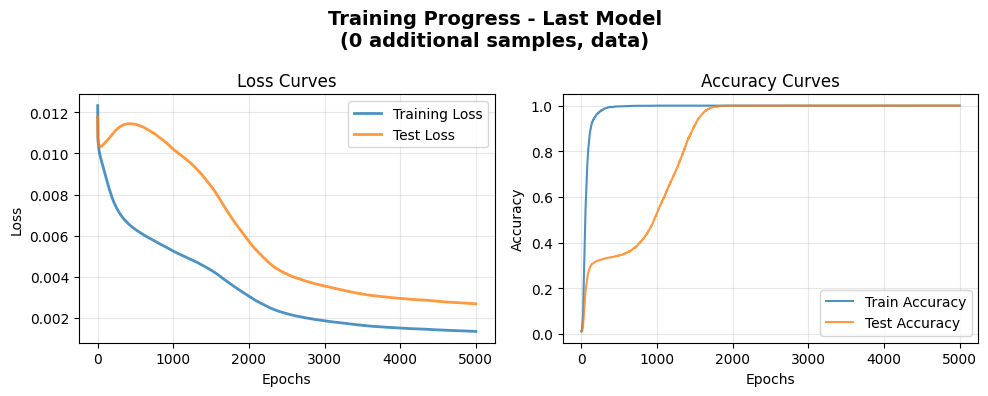


=== Final Metrics Summary ===
Metric               Training   Test       Gap       
--------------------------------------------------
Loss                 0.0013     0.0027     0.0013    
Accuracy             1.0000     1.0000     0.0000    


In [5]:
# ====================================
# Plotting for Last Model
# ====================================

# Get the last model from the list
last_model_data = all_models[-1]

print("=== Last Model Data Keys ===")
print(list(last_model_data.keys()))

print(f"\n=== Model Info ===")
print(f"Additional data: {last_model_data['additional_data']}")
print(f"Dataset type: {last_model_data['dataset_type']}")
print(f"Total epochs trained: {last_model_data.get('total_epochs_trained', 'Not specified')}")

print(f"\n=== Loss Statistics ===")
print(f"Train loss length: {len(last_model_data['train_loss'])}")
print(f"Test loss length: {len(last_model_data['test_loss'])}")
print(f"Final train loss: {last_model_data['train_loss'][-1]:.4f}")
print(f"Final test loss: {last_model_data['test_loss'][-1]:.4f}")

# --- Explicitly check if accuracy keys exist ---
has_train_acc = "train_accs" in last_model_data
has_test_acc = "test_accs" in last_model_data

print("\n=== Debug: Accuracy Keys ===")
print(f"train_accuracy present? {has_train_acc}")
print(f"test_accuracy present? {has_test_acc}")

# --- Create subplots: loss + accuracy (if available) ---
n_plots = 1 + (1 if has_train_acc or has_test_acc else 0)
n_cols = 2
n_rows = (n_plots + n_cols - 1) // n_cols  # ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
if isinstance(axes, np.ndarray):
    axes = axes.flatten()
else:
    axes = [axes]

fig.suptitle(f'Training Progress - Last Model\n'
             f'({last_model_data["additional_data"]} additional samples, {last_model_data["dataset_type"]})',
             fontsize=14, fontweight='bold')
fig.suptitle(f'Training Progress - Last Model\n'
             f'({last_model_data["additional_data"]} additional samples, {last_model_data["dataset_type"]})',
             fontsize=14, fontweight='bold')

# --- Plot 1: Loss ---
ax_idx = 0
axes[ax_idx].plot(last_model_data["train_loss"], label='Training Loss', alpha=0.8, linewidth=2)
axes[ax_idx].plot(last_model_data["test_loss"], label='Test Loss', alpha=0.8, linewidth=2)
axes[ax_idx].set_xlabel('Epochs')
axes[ax_idx].set_ylabel('Loss')
axes[ax_idx].set_title('Loss Curves')
axes[ax_idx].legend()
axes[ax_idx].grid(True, alpha=0.3)

# --- Plot 2: Accuracy (if present) ---
if has_train_acc or has_test_acc:
    ax_idx += 1
    if has_train_acc:
        axes[ax_idx].plot(last_model_data["train_accs"], label='Train Accuracy', alpha=0.8)
    if has_test_acc:
        axes[ax_idx].plot(last_model_data["test_accs"], label='Test Accuracy', alpha=0.8)
    axes[ax_idx].set_xlabel('Epochs')
    axes[ax_idx].set_ylabel('Accuracy')
    axes[ax_idx].set_title('Accuracy Curves')
    axes[ax_idx].legend()
    axes[ax_idx].grid(True, alpha=0.3)

# Hide any unused subplots
for i in range(ax_idx + 1, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

# --- Print Final Summary ---
print(f"\n=== Final Metrics Summary ===")
print(f"{'Metric':<20} {'Training':<10} {'Test':<10} {'Gap':<10}")
print("-" * 50)
print(f"{'Loss':<20} {last_model_data['train_loss'][-1]:<10.4f} {last_model_data['test_loss'][-1]:<10.4f} "
      f"{abs(last_model_data['train_loss'][-1] - last_model_data['test_loss'][-1]):<10.4f}")

if has_train_acc and has_test_acc:
    gap = abs(last_model_data["train_accs"][-1] - last_model_data["test_accs"][-1])
    print(f"{'Accuracy':<20} {last_model_data['train_accs'][-1]:<10.4f} {last_model_data['test_accs'][-1]:<10.4f} {gap:<10.4f}")
elif has_train_acc:
    print(f"{'Accuracy':<20} {last_model_data['train_accs'][-1]:<10.4f} {'N/A':<10} {'N/A':<10}")
elif has_test_acc:
    print(f"{'Accuracy':<20} {'N/A':<10} {last_model_data['test_accs'][-1]:<10.4f} {'N/A':<10}")

## Model Saving

In [6]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_epoch_{model_data['total_epochs_trained']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_loss=model_data["train_loss"],
            train_accs=model_data["train_accs"],
            test_loss=model_data["test_loss"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
            total_epochs_trained=model_data["total_epochs_trained"]
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_epoch_200.pt
Saved model: models_and_data/model_epoch_200.pt
✅ Model saved to models_and_data\model_epoch_400.pt
Saved model: models_and_data/model_epoch_400.pt
✅ Model saved to models_and_data\model_epoch_600.pt
Saved model: models_and_data/model_epoch_600.pt
✅ Model saved to models_and_data\model_epoch_800.pt
Saved model: models_and_data/model_epoch_800.pt
✅ Model saved to models_and_data\model_epoch_1000.pt
Saved model: models_and_data/model_epoch_1000.pt
✅ Model saved to models_and_data\model_epoch_1500.pt
Saved model: models_and_data/model_epoch_1500.pt
✅ Model saved to models_and_data\model_epoch_2000.pt
Saved model: models_and_data/model_epoch_2000.pt
✅ Model saved to models_and_data\model_epoch_3000.pt
Saved model: models_and_data/model_epoch_3000.pt
✅ Model saved to models_and_data\model_epoch_5000.pt
Saved model: models_and_data/model_epoch_5000.pt
